In [10]:
import os
print(os.path.exists(r"best_model_fold_1.h5"))  # Using raw string

# OR
print(os.path.exists("Downloads/best_model_fold_1.h5"))  


True
False


2025-02-18 08:55:41,354 - INFO - 🚀 Loading model from best_model_fold_1.h5
2025-02-18 08:55:41,769 - WARNING - Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
2025-02-18 08:55:41,784 - INFO - 🚀 Loading test data: E:\Projects\NeuroMan ML SYNC\Control sublects arm dataset\Arms\Control_1_L.xlsx
2025-02-18 08:55:42,805 - INFO - 🚀 Loading test data: E:\Projects\NeuroMan ML SYNC\Patient arm dataset\Arms\Patient_10_R.xlsx
2025-02-18 08:55:43,189 - INFO - 🚀 Preprocessing test data...
2025-02-18 08:55:43,195 - INFO - 🚀 Preprocessing test data...
2025-02-18 08:55:43,199 - INFO - ✅ Combined test dataset size: (5322, 12, 1)
2025-02-18 08:55:43,200 - INFO - 🚀 Evaluating the model on test data...


167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step


2025-02-18 08:55:49,302 - INFO - 
📊 Test Results:
2025-02-18 08:55:49,304 - INFO - Accuracy: 0.4532
2025-02-18 08:55:49,306 - INFO - Precision: 0.4532
2025-02-18 08:55:49,314 - INFO - Recall: 1.0000
2025-02-18 08:55:49,317 - INFO - F1: 0.6237
2025-02-18 08:55:49,319 - INFO - Roc_auc: 0.8034


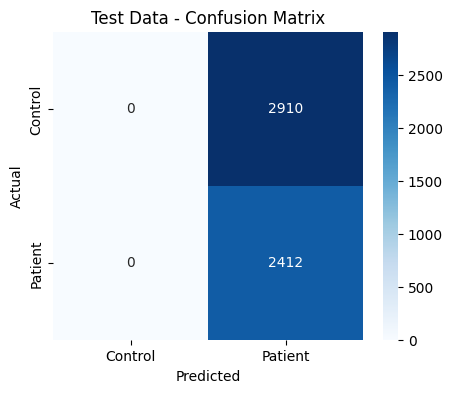

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


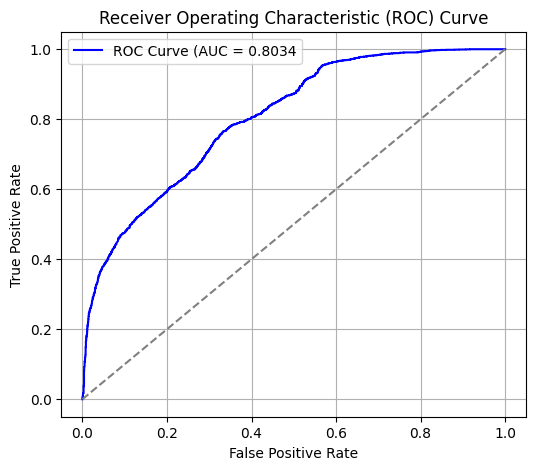

167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


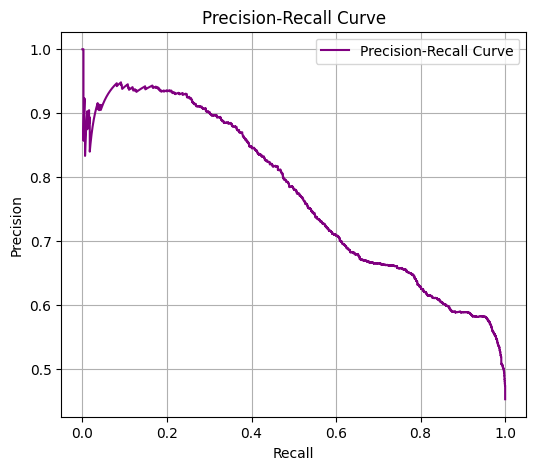

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


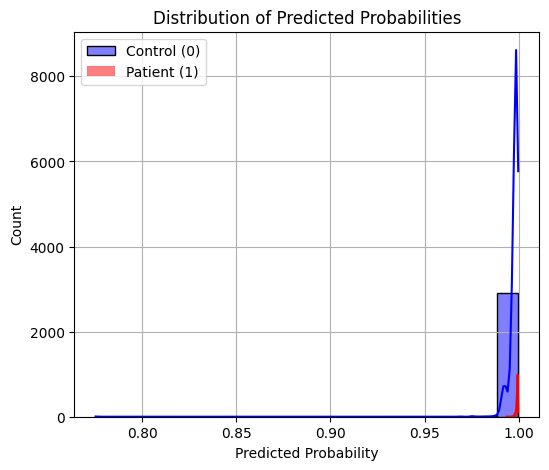

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve)

# Setup logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Paths to test data and trained model
CONTROL_PATH = r"E:\Projects\NeuroMan ML SYNC\Control sublects arm dataset\Arms\Control_1_L.xlsx"
PATIENT_PATH = r"E:\Projects\NeuroMan ML SYNC\Patient arm dataset\Arms\Patient_10_R.xlsx"
MODEL_PATH = "best_model_fold_1.h5"

def load_test_data(file_path: str) -> np.ndarray:
    """Load a dataset for testing."""
    logging.info(f"🚀 Loading test data: {file_path}")
    try:
        df = pd.read_excel(file_path)
        if df.empty:
            raise ValueError(f"Test file {file_path} is empty!")
        return df.values
    except Exception as e:
        logging.error(f"❌ Error loading test file: {str(e)}")
        return None

def preprocess_data(X: np.ndarray, scaler: MinMaxScaler) -> np.ndarray:
    """Preprocess test data (imputation, scaling, reshaping)."""
    logging.info("🚀 Preprocessing test data...")
    
    if X is None or X.shape[0] == 0:
        raise ValueError("No valid data found for preprocessing!")
    
    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X)
    
    X_scaled = scaler.transform(X_imputed)  # Use pre-fitted scaler to avoid data leakage
    X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
    
    return X_reshaped

def evaluate_model(model: tf.keras.Model, X_test: np.ndarray, y_test: np.ndarray):
    """Evaluate the trained model on the test dataset."""
    logging.info("🚀 Evaluating the model on test data...")
    
    y_pred_probs = model.predict(X_test).ravel()
    y_pred = (y_pred_probs > 0.591).astype(int)
    
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=1),
        "recall": recall_score(y_test, y_pred, zero_division=1),
        "f1": f1_score(y_test, y_pred, zero_division=1),
        "roc_auc": roc_auc_score(y_test, y_pred_probs) if len(set(y_test)) > 1 else float("nan")
    }
    
    logging.info("\n📊 Test Results:")
    for metric, value in metrics.items():
        logging.info(f"{metric.capitalize()}: {value:.4f}")
    
    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Control", "Patient"],
                yticklabels=["Control", "Patient"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Test Data - Confusion Matrix")
    plt.savefig("confusion_matrix_test.png")
    plt.show()

def plot_roc_curve(y_test, y_pred_probs):
    """Plot the ROC Curve."""
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_pred_probs):.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.grid()
    plt.savefig("roc_curve_test.png")
    plt.show()

def plot_precision_recall(y_test, y_pred_probs):
    """Plot the Precision-Recall Curve."""
    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color="purple", label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.savefig("precision_recall_curve_test.png")
    plt.show()

def plot_prediction_distribution(y_test, y_pred_probs):
    """Plot the predicted probability distribution."""
    plt.figure(figsize=(6, 5))
    sns.histplot(y_pred_probs[y_test == 0], color="blue", label="Control (0)", kde=True, bins=20)
    sns.histplot(y_pred_probs[y_test == 1], color="red", label="Patient (1)", kde=True, bins=20)
    plt.xlabel("Predicted Probability")
    plt.ylabel("Count")
    plt.title("Distribution of Predicted Probabilities")
    plt.legend()
    plt.grid()
    plt.savefig("prediction_distribution_test.png")
    plt.show()

if __name__ == "__main__":
    try:
        logging.info(f"🚀 Loading model from {MODEL_PATH}")
        model = tf.keras.models.load_model(MODEL_PATH)

        scaler = MinMaxScaler()
        
        X_control = load_test_data(CONTROL_PATH)
        X_patient = load_test_data(PATIENT_PATH)
        
        if X_control is None or X_patient is None:
            raise ValueError("One of the test datasets could not be loaded!")
        
        scaler.fit(np.vstack((X_control, X_patient)))  # Fit scaler on combined data
        X_control_processed = preprocess_data(X_control, scaler)
        X_patient_processed = preprocess_data(X_patient, scaler)
        
        y_control = np.zeros(X_control_processed.shape[0])
        y_patient = np.ones(X_patient_processed.shape[0])
        
        X_test = np.concatenate((X_control_processed, X_patient_processed), axis=0)
        y_test = np.concatenate((y_control, y_patient), axis=0)
        
        logging.info(f"✅ Combined test dataset size: {X_test.shape}")
        evaluate_model(model, X_test, y_test)
        plot_roc_curve(y_test, model.predict(X_test).ravel())
        plot_precision_recall(y_test, model.predict(X_test).ravel())
        plot_prediction_distribution(y_test, model.predict(X_test).ravel())

    except Exception as e:
        logging.error(f"❌ Error during testing: {str(e)}")


In [14]:
import os

control_path = r"E:\Projects\NeuroMan Health Hack\Control sublects arm dataset\Arms\Control_1_L.xlsx"
patient_path = r"E:\Projects\NeuroMan Health Hack\Patient arm dataset\Arms\Patient_10_R.xlsx"

print(f"Control path exists: {os.path.exists(control_path)}")
print(f"Patient path exists: {os.path.exists(patient_path)}")


Control path exists: True
Patient path exists: True


In [15]:
import os

control_files = os.listdir(control_path)
patient_files = os.listdir(patient_path)

print(f"Files in Control Path: {control_files}")
print(f"Files in Patient Path: {patient_files}")


NotADirectoryError: [WinError 267] The directory name is invalid: 'E:\\Projects\\NeuroMan Health Hack\\Control sublects arm dataset\\Arms\\Control_1_L.xlsx'

In [16]:
import os

control_file_path = r"E:\Projects\NeuroMan Health Hack\Control sublects arm dataset\Arms\Control_1_L.xlsx"
patient_file_path = r"E:\Projects\NeuroMan Health Hack\Patient arm dataset\Arms\Patient_10_R.xlsx"

print(f"Control file exists: {os.path.exists(control_file_path)}")
print(f"Patient file exists: {os.path.exists(patient_file_path)}")


Control file exists: True
Patient file exists: True


2025-02-18 08:35:38,330 - INFO - 🚀 Loading model from best_model_fold_1.h5
2025-02-18 08:35:38,465 - WARNING - Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
2025-02-18 08:35:38,473 - INFO - 🚀 Loading test data...
2025-02-18 08:35:38,741 - INFO - 🚀 Preprocessing test data...
2025-02-18 08:35:38,743 - WARNING - ⚠ No saved scaler found! Using independent scaling (may cause accuracy drop).
2025-02-18 08:35:38,745 - INFO - 🚀 Evaluating the model on test data...


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


c:\Users\Ankit Mishra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
2025-02-18 08:35:40,327 - INFO - 
📊 Test Results:
2025-02-18 08:35:40,328 - INFO - Accuracy: 0.9988
2025-02-18 08:35:40,329 - INFO - Precision: 1.0000
2025-02-18 08:35:40,330 - INFO - Recall: 0.9988
2025-02-18 08:35:40,331 - INFO - F1: 0.9994
2025-02-18 08:35:40,332 - INFO - Roc_auc: nan


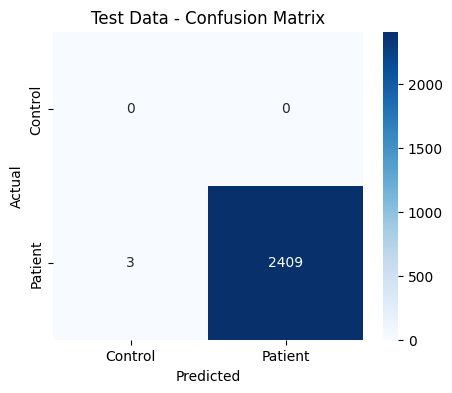

In [20]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Setup logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Paths to test data, trained model, and scaler
TEST_FILE = r"E:\Projects\NeuroMan Health Hack\Patient arm dataset\Arms\Patient_10_R.xlsx"
MODEL_PATH = "best_model_fold_1.h5"
SCALER_PATH = "scaler.pkl"  # Ensure this scaler is saved during training
BEST_THRESHOLD = 0.591  # From your ROC analysis

def load_test_data(file_path: str) -> np.ndarray:
    """Load a single dataset for testing."""
    logging.info("🚀 Loading test data...")
    try:
        df = pd.read_excel(file_path)
        if df.empty:
            raise ValueError("Test file is empty!")
        return df.values
    except Exception as e:
        logging.error(f"❌ Error loading test file: {str(e)}")
        raise

def preprocess_data(X: np.ndarray, scaler_path: str) -> np.ndarray:
    """Preprocess test data (imputation, scaling, reshaping)."""
    logging.info("🚀 Preprocessing test data...")

    # Handle missing values
    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X)

    # Load saved MinMaxScaler (avoid data leakage)
    if os.path.exists(scaler_path):
        scaler = joblib.load(scaler_path)
        logging.info("✅ Using saved MinMaxScaler from training.")
        X_scaled = scaler.transform(X_imputed)
    else:
        logging.warning("⚠ No saved scaler found! Using independent scaling (may cause accuracy drop).")
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X_imputed)

    # Reshape for LSTM (samples, timesteps, features) if needed
    X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)  
    return X_reshaped

def evaluate_model(model: tf.keras.Model, X_test: np.ndarray, y_test: np.ndarray):
    """Evaluate the trained model on the test dataset."""
    logging.info("🚀 Evaluating the model on test data...")

    # Generate predictions
    y_pred_probs = model.predict(X_test).ravel()
    y_pred = (y_pred_probs > BEST_THRESHOLD).astype(int)  # Use best threshold

    # Calculate metrics
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_pred_probs)
    }

    # Log results
    logging.info("\n📊 Test Results:")
    for metric, value in metrics.items():
        logging.info(f"{metric.capitalize()}: {value:.4f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Control", "Patient"],
                yticklabels=["Control", "Patient"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Test Data - Confusion Matrix")
    plt.savefig("confusion_matrix_test.png")
    plt.show()

if __name__ == "__main__":
    try:
        # Load trained model
        logging.info(f"🚀 Loading model from {MODEL_PATH}")
        model = tf.keras.models.load_model(MODEL_PATH)

        # Load and preprocess test data
        X_test = load_test_data(TEST_FILE)
        X_test_processed = preprocess_data(X_test, SCALER_PATH)

        # Create dummy labels based on filename (Change this as needed)
        if "Control" in TEST_FILE:
            y_test = np.zeros(X_test_processed.shape[0])  # Control samples = 0
        else:
            y_test = np.ones(X_test_processed.shape[0])   # Patient samples = 1

        # Evaluate the model
        evaluate_model(model, X_test_processed, y_test)

    except Exception as e:
        logging.error(f"❌ Error during testing: {str(e)}")
        raise